This notebook is concerned with the [Google Brain - Ventilator Pressure Prediction challenge](https://www.kaggle.com/competitions/ventilator-pressure-prediction/overview). We will use a LSTM model to predict time series of pressure values.

In [1]:
import absl.logging
import logging
import random 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import kaggle
import zipfile
import math
import copy

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, RepeatVector, TimeDistributed 
from tensorflow.keras.losses import MeanAbsoluteError

tf.random.set_seed(42)
random.seed(42)
absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)

print(f"Tensorflow version: {tf.__version__}")
print(f"Numpy version: {np.__version__}")

Tensorflow version: 2.5.0
Numpy version: 1.19.5


# Loading data and exploratory data analysis
Let's download the dataset from Kaggle:

In [2]:
kaggle.api.authenticate()
# kaggle.api.competitions_list(search="ventilator")
kaggle.api.competition_download_files("ventilator-pressure-prediction", path="./dataset")
with zipfile.ZipFile("./dataset/ventilator-pressure-prediction.zip", "r") as zipObj:
    zipObj.extractall(path="./dataset")

df = pd.read_csv("./dataset/train.csv")
df.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


Let's explore the data a little bit:

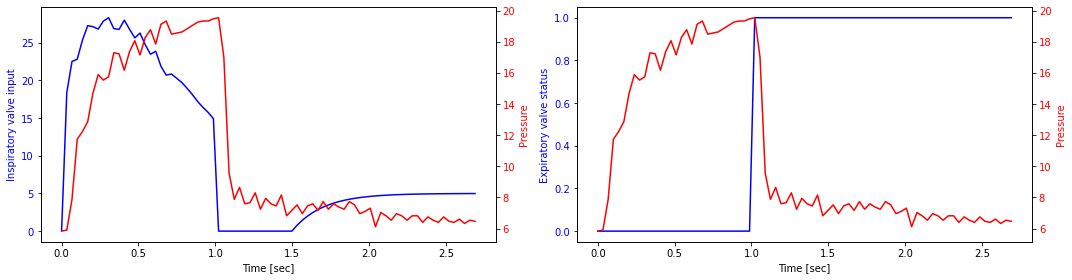

In [3]:
breath_id = 1
cur_time_series = df[df["breath_id"] == breath_id]

# 1st plot
fig, ax_a = plt.subplots(1, 2, figsize=(15,4))
ax_a[0].plot(cur_time_series["time_step"], cur_time_series["u_in"], color="b")
ax_a[0].set_xlabel("Time [sec]")
ax_a[0].set_ylabel("Inspiratory valve input", color="b")
ax_a[0].tick_params(axis="y", labelcolor="b")
ax_b = ax_a[0].twinx() 
ax_b.plot(cur_time_series["time_step"], cur_time_series["pressure"], color="r", label="zz")
ax_b.set_ylabel("Pressure", color="r")
ax_b.tick_params(axis="y", labelcolor="r")

# 2nd plot
ax_a[1].plot(cur_time_series["time_step"], cur_time_series["u_out"], color="b")
ax_a[1].set_xlabel("Time [sec]")
ax_a[1].set_ylabel("Expiratory valve status", color="b")
ax_a[1].tick_params(axis="y", labelcolor="b")
ax_b = ax_a[1].twinx() 
ax_b.plot(cur_time_series["time_step"], cur_time_series["pressure"], color="r", label="zz")
ax_b.set_ylabel("Pressure", color="r")
ax_b.tick_params(axis="y", labelcolor="r")
plt.tight_layout()
plt.show()

In [4]:
print(f"""There are {len(df.breath_id.unique())} time series in the data set.""")

print(f"""For each individual time series, there are on average {df.breath_id.value_counts().mean()} time points \
with a variance of {df.breath_id.value_counts().var()}.""")

print(f"""However, this does not mean all individual time series are of the same length. The shortest time series \
is {df.groupby("breath_id")["time_step"].max().min():.3f} s long, the \
longest {df.groupby("breath_id")["time_step"].max().max():.3f} s.""")

There are 75450 time series in the data set.
For each individual time series, there are on average 80.0 time points with a variance of 0.0.
However, this does not mean all individual time series are of the same length. The shortest time series is 2.497 s long, the longest 2.937 s.


In [5]:
print(f"""For R, which is a lung attribute indicating how restricted the airway is, only three distinct values are \
found in the data set: {df.R.unique()}.""")

print(f"""The value of R within each individual time series is constant as indicated by a variance \
of: {df.groupby("breath_id")[["R"]].var()["R"].unique()}.""")

For R, which is a lung attribute indicating how restricted the airway is, only three distinct values are found in the data set: [20 50  5].
The value of R within each individual time series is constant as indicated by a variance of: [0].


In [6]:
print(f"""For C, which is a lung attribute indicating how compliant the lung is, only three distinct values are \
found in the data set: {df.C.unique()}.""")

print(f"""The value of C within each individual time series is constant as indicated by a variance \
of: {df.groupby("breath_id")[["C"]].var()["C"].unique()}.""")

For C, which is a lung attribute indicating how compliant the lung is, only three distinct values are found in the data set: [50 20 10].
The value of C within each individual time series is constant as indicated by a variance of: [0].


In [7]:
print(f"There is no missing data in the data set: \n{df.isnull().sum()}")

There is no missing data in the data set: 
id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64


# Data preprocessing

Now, we will perform some preprocessing of the data. Even though R and C might be continuous variables, they both only have three distinct values in the data set. Therefore, it is likely better to treat them as categorical variables. Consequently, we will one-hot encode them. Furthermore, we will drop the "id" column as it contains no relevant information. We also drop the breath "breath_ID" because we will reshape the data in the next step in a way that makes this information obsolete: 

In [8]:
df_transformed = df.drop(columns=["id", "breath_id"])

transformer = make_column_transformer((OneHotEncoder(drop="first"), ["R", "C"]), remainder="passthrough")
df_transformed = transformer.fit_transform(df_transformed)
df_transformed = pd.DataFrame(df_transformed, columns=transformer.get_feature_names_out())
df_transformed.head()

,onehotencoder__R_20,onehotencoder__R_50,onehotencoder__C_20,onehotencoder__C_50,remainder__time_step,remainder__u_in,remainder__u_out,remainder__pressure
0,1.0,0.0,0.0,1.0,0.000000,0.083334,0.0,5.837492
1,1.0,0.0,0.0,1.0,0.033652,18.383041,0.0,5.907794
2,1.0,0.0,0.0,1.0,0.067514,22.509278,0.0,7.876254
3,1.0,0.0,0.0,1.0,0.101542,22.808822,0.0,11.742872
4,1.0,0.0,0.0,1.0,0.135756,25.355850,0.0,12.234987


Now, we will convert the data to a numpy array so that it has following shape (number of breath IDs, number of time points, number of features). Then, we split the data into train and test set:

In [9]:
X = df_transformed.iloc[:,:-1].to_numpy()
y = df_transformed.iloc[:,-1].to_numpy()
X = X.reshape((X.shape[0]//80, 80, -1))
y = y.reshape((y.shape[0]//80, 80, -1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f"The shape of the numpy array of the independent variables of the training data is: {X_train.shape}.")
print(f"The shape of the numpy array of the dependent variable of the training data is: {y_train.shape}.")

The shape of the numpy array of the independent variables of the training data is: (50551, 80, 7).
The shape of the numpy array of the dependent variable of the training data is: (50551, 80, 1).


We perform min-max scaling of the "time_step", "u_in", and the "pressure" feature:

In [10]:
class MinMax:
    def fit(self, X):
        self.min = np.min(X)
        self.max = np.max(X)
        return self
        
    def transform(self, X):
        X_scaled = (X - self.min) / (self.max - self.min) 
        return X_scaled
    
    def backtransform(self, X_scaled):
        X = X_scaled * (self.max - self.min) + self.min
        return X
    

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
y_train_scaled = y_train.copy()
y_test_scaled = y_test.copy()

scaler_time_step = MinMax().fit(X_train[:, :, 4])    
X_train_scaled[:, :, 4] = scaler_time_step.transform(X_train[:, :, 4])
X_test_scaled[:, :, 4] = scaler_time_step.transform(X_test[:, :, 4])

scaler_u_in = MinMax().fit(X_train[:, :, 5])    
X_train_scaled[:, :, 5] = scaler_u_in.transform(X_train[:, :, 5])
X_test_scaled[:, :, 5] = scaler_u_in.transform(X_test[:, :, 5])

scaler_pressure = MinMax().fit(y_train)
y_train_scaled = scaler_pressure.transform(y_train)
y_test_scaled = scaler_pressure.transform(y_test)

# Model
Let's create some data set loader, define the LSTM network architecture, and train our model:

In [11]:
batch_size = 32
shuffle_buffer_size = X_train_scaled.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_scaled))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_scaled))
train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [12]:
def lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Bidirectional(LSTM(64))(x)
    x = RepeatVector(80)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = TimeDistributed(Dense(128, activation="relu"))(x)
    outputs = TimeDistributed(Dense(1, activation="linear"))(x)

    model = Model(inputs=inputs, outputs=outputs)
    tf.keras.utils.plot_model(model, to_file="lstm.png", show_shapes=True)
    model.summary()
    return model

lstm1 = lstm_model(input_shape=(80,7))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 7)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 256)           139264    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 80, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 256)           263168    
_________________________________________________________________
time_distributed (TimeDistri (None, 80, 128)           32896     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 80, 1)             129   

In [13]:
def scheduler(epoch, lr): 
    return lr * 0.985

lstm1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss="mse")
cb1 = callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)               
cb2 = callbacks.LearningRateScheduler(scheduler)
cb3 = callbacks.ModelCheckpoint(".\\lstm1", monitor="val_loss", save_best_only=True)

history = lstm1.fit(train_dataset, epochs=350,  validation_data=test_dataset,
                    verbose=1, callbacks=[cb1, cb2, cb3])

Epoch 1/350
1580/1580 [==============================] - 413s 257ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 2/350
1580/1580 [==============================] - 441s 279ms/step - loss: 9.0285e-04 - val_loss: 7.0241e-04
Epoch 3/350
1580/1580 [==============================] - 592s 375ms/step - loss: 6.6362e-04 - val_loss: 5.8112e-04
Epoch 4/350
1580/1580 [==============================] - 661s 418ms/step - loss: 5.7031e-04 - val_loss: 4.8846e-04
Epoch 5/350
1580/1580 [==============================] - 751s 475ms/step - loss: 4.9585e-04 - val_loss: 3.9502e-04
Epoch 6/350
1580/1580 [==============================] - 865s 548ms/step - loss: 4.2968e-04 - val_loss: 3.4063e-04
Epoch 7/350
1580/1580 [==============================] - 970s 614ms/step - loss: 5.8032e-04 - val_loss: 3.7904e-04
Epoch 8/350
1580/1580 [==============================] - 972s 615ms/step - loss: 3.5280e-04 - val_loss: 2.7969e-04
Epoch 9/350
1580/1580 [==============================] - 870s 550ms/step - loss: 3.0772e

1580/1580 [==============================] - 1022s 647ms/step - loss: 7.5023e-05 - val_loss: 9.2215e-05
Epoch 72/350
1580/1580 [==============================] - 1028s 650ms/step - loss: 7.5975e-05 - val_loss: 8.7126e-05
Epoch 73/350
1580/1580 [==============================] - 1043s 660ms/step - loss: 7.3682e-05 - val_loss: 8.2055e-05
Epoch 74/350
1580/1580 [==============================] - 1180s 747ms/step - loss: 7.4374e-05 - val_loss: 8.2556e-05
Epoch 75/350
1580/1580 [==============================] - 1172s 742ms/step - loss: 7.6604e-05 - val_loss: 1.4928e-04
Epoch 76/350
1580/1580 [==============================] - 1161s 735ms/step - loss: 7.8622e-05 - val_loss: 8.1762e-05
Epoch 77/350
1580/1580 [==============================] - 1241s 785ms/step - loss: 7.3305e-05 - val_loss: 8.3518e-05
Epoch 78/350
1580/1580 [==============================] - 1162s 735ms/step - loss: 7.0767e-05 - val_loss: 8.0293e-05
Epoch 79/350
1580/1580 [==============================] - 1205s 763ms/step - 

1580/1580 [==============================] - 1702s 1s/step - loss: 4.8796e-05 - val_loss: 6.8011e-05
Epoch 142/350
1580/1580 [==============================] - 1570s 994ms/step - loss: 4.8526e-05 - val_loss: 6.7170e-05
Epoch 143/350
1580/1580 [==============================] - 1615s 1s/step - loss: 4.8879e-05 - val_loss: 6.6321e-05
Epoch 144/350
1580/1580 [==============================] - 1693s 1s/step - loss: 4.9664e-05 - val_loss: 6.5252e-05
Epoch 145/350
1580/1580 [==============================] - 1372s 868ms/step - loss: 4.7773e-05 - val_loss: 6.8730e-05
Epoch 146/350
1580/1580 [==============================] - 1372s 869ms/step - loss: 4.8508e-05 - val_loss: 6.6974e-05
Epoch 147/350
1580/1580 [==============================] - 1383s 875ms/step - loss: 4.7552e-05 - val_loss: 6.5605e-05
Epoch 148/350
1580/1580 [==============================] - 1416s 896ms/step - loss: 4.7580e-05 - val_loss: 6.5055e-05
Epoch 149/350
1580/1580 [==============================] - 1274s 806ms/step - l

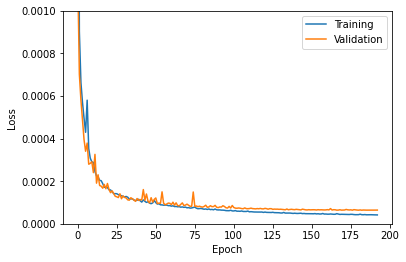

In [14]:
fig, ax = plt.subplots()
ax.plot(history.history["loss"], label="Training")
ax.plot(history.history["val_loss"], label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_ylim(0, 0.001)
ax.legend()
plt.tight_layout(pad=2.0)
plt.show()

# Predict
Now, let's have a look how our model performs on the test set:

In [15]:
lstm1 = tf.keras.models.load_model(".\\lstm1", compile=False)
y_test_pred = lstm1.predict(test_dataset)
y_test_pred = scaler_pressure.backtransform(y_test_pred)

mae = MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
result = np.mean(mae(y_test, y_test_pred).numpy())
print(f"""The overall mean absolute error on the test set is: {result:.2f}.""")

The overall mean absolute error on the test set is: 0.33.


Furthermore, let's visualize one of the time series to get an more informed idea what an mean absolute error of this magnitude means in practice:

The mean absolute error of this particular time series is: 0.31.


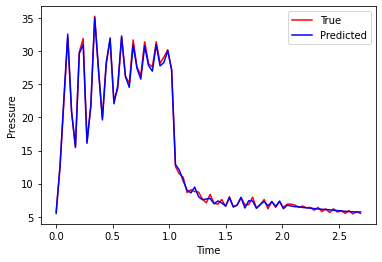

In [16]:
breath_id = 5000
mae = MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
result = np.mean(mae(y_test[breath_id], y_test_pred[breath_id]).numpy())
print(f"""The mean absolute error of this particular time series is: {result:.2f}.""")

fig, ax = plt.subplots()
ax.plot(X_test[breath_id,:,4], y_test[breath_id], color="r", label="True")
ax.plot(X_test[breath_id,:,4], y_test_pred[breath_id], color="b", label="Predicted")
ax.set_ylabel("Pressure")
ax.set_xlabel("Time")
ax.legend()
plt.show()

Looks quite good!